# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install xgboost

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
import pickle
import os
from scipy.stats import skew
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

#Part 1
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

#Part 2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
#multicoloured bars default
#https://stackoverflow.com/questions/57181569/random-colors-by-default-in-matplotlib
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
#azdias = pd.read_csv('Arvato_data/Udacity_AZDIAS_052018.csv', sep=';',low_memory=False)

In [5]:
#customers = pd.read_csv('Arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',low_memory=False)

In [6]:
# pickle dataframes to speed-up data loading next time
#azdias.to_pickle('azdias.pickle')
#customers.to_pickle('customers.pickle')

### Data Exploration / Visualization

In [7]:
# load pickled data
azdias = pd.read_pickle('azdias.pickle')

In [8]:
customers = pd.read_pickle('customers.pickle')

In [11]:
# Shape of general population and customers:
print("Shape of AZDIAS: {} rows, {} columns".format(azdias.shape[0], azdias.shape[1]))
print("Shape of Customers: {} rows, {} columns".format(customers.shape[0], customers.shape[1]))

Shape of AZDIAS: 891221 rows, 366 columns
Shape of Customers: 191652 rows, 369 columns


In [12]:
#Comparing the two datasets - 3 extra columns in Customers
azd_col = set(azdias.columns)
cust_col = set(customers.columns)
cust_extra_col = azd_col.symmetric_difference(cust_col)

print(cust_extra_col)

{'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}


### Type of data

In [15]:
print("Azdias data types: ")
print(azdias.dtypes.value_counts())
print("Customers data types: ")
print(customers.dtypes.value_counts()) 

Azdias data types: 
float64    267
int64       93
object       6
dtype: int64
Customers data types: 
float64    267
int64       94
object       8
dtype: int64


In [17]:
azdias.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [16]:
customers.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


Azdias has 6 categorical columns whereas customers has 2 extra columns:

    1. CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015: Socio-economic and geodemographic information of households based on CAMEO Typology.
    2. D19_LETZTER_KAUF_BRANCHE: The category of the latest buy of a household.
    3. EINGEFUEGT_AM:Date when a household was added to the database.
    4. OST_WEST_KZ: Area in which the building was located - former East Germany (O) or former West Germany (W).
    5. PRODUCT_GROUP / CUSTOMER_GROUP: Columns related to customer buying habits.

In [18]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [19]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [60]:
print(azdias.info())
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


In [20]:
#column 18 and 19 have mixed values.
print(azdias.iloc[:,18].value_counts())
print(azdias.iloc[:,19].value_counts())

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64
51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
XX       373
Name: CAMEO_INTL_2015, dtype: int64


In [21]:
#Replace values "X", "XX" and convert all values to float
#azdias['CAMEO_INTL_2015'].replace(['X','XX'], [np.nan,np.nan], inplace = True)
#azdias['CAMEO_DEUG_2015'].replace(['X','XX'], [np.nan,np.nan], inplace = True)

In [22]:
#azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)
#azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)

### Fill Missing Values

In [23]:
def fill_na(df, col):
    '''
    Fill NA/NaN values using the last valid observation.
    
        Parameters:
            df: dataframe
            col: column name

        Returns:
            dataframe with filled value
    '''
    df[col].fillna(method = 'ffill', inplace = True)
    return df

In [24]:
#attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx',engine='openpyxl',header = 1, usecols = range(1,5))
##attributes_info['Information level'] = df['Information level'].fillna(method = 'ffill', inplace = True)
#attributes_info = fill_na(attributes_info,'Information level')

feature_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx',engine='openpyxl', header = 1, usecols = range(1,6))
feature_info = fill_na(feature_info, 'Attribute')
feature_info = fill_na(feature_info, 'Description')

In [25]:
feature_info.head(8)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years


In [26]:
#feature_info
missing_values = feature_info[feature_info["Meaning"].isin(["unknown","unknown / no main age detectable"])]
missing_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


The unknown values will be converted to NaN using a dictionary

In [30]:
#Dictionary of unknown attributes 
missing_values_dict = {}

for _, row in missing_values.iterrows():
    key = row['Attribute']
    missing_values_dict[key] = str(row["Value"]).split(', ')
    
len(missing_values_dict)

233

In [32]:
# Manually add unknown codes from other attributes 
missing_values_dict["CAMEO_INTL_2015"] = ['XX']
missing_values_dict["CAMEO_DEUG_2015"] = ['X','XX']
missing_values_dict["CAMEO_DEU_2015"] =['XX']
missing_values_dict["GEBURTSJAHR"] = ['0']
missing_values_dict["CAMEO_INTL_2015"] == missing_values_dict["CAMEO_DEUINTL_2015"]
missing_values_dict["KBA13_CCM_1401_2500"] = missing_values_dict["KBA13_CCM_1400_2500"]
missing_values_dict["KBA13_BAUMAX"] = missing_values_dict["KBA05_BAUMAX"]
missing_values_dict["KBA13_ANTG1"] =  missing_values_dict["KBA05_ANTG1"]
missing_values_dict["KBA13_ANTG2"] =  missing_values_dict["KBA05_ANTG2"]
missing_values_dict["KBA13_ANTG3"] =  missing_values_dict["KBA05_ANTG3"]
missing_values_dict["KBA13_ANTG4"] =  missing_values_dict["KBA05_ANTG4"]
len(missing_values_dict)

242

In [34]:
for attribute in missing_values_dict:
    if attribute in azdias.columns:             # Check if attribute is in dataframe columns    
        keys = missing_values_dict[attribute]
        for key in keys:
            if key == 'X' or key == 'XX':
                key = str(key)
            else:
                key = int(key)
                
            azdias[attribute].replace(key, np.NaN, inplace=True)

### Missing Columns

In [35]:
null_col_azd = azdias.isnull().sum()                            #Number of missing values in columns
null_col_azd_percentage = azdias.isnull().sum()/len(azdias)*100 #Percentage of missing values in columns

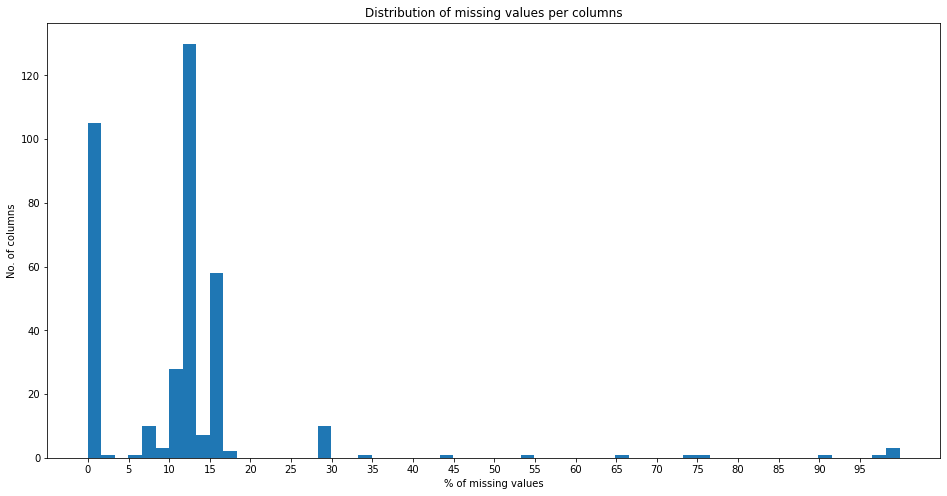

In [36]:
plt.figure(figsize=(16,8))
plt.hist(null_col_azd_percentage,bins=60)

plt.xticks(np.arange(0, 100, 5))
plt.xlabel('% of missing values')
plt.ylabel('No. of columns')
plt.title('Distribution of missing values per columns')
plt.show()

Text(0, 0.5, 'Missing values percentage')

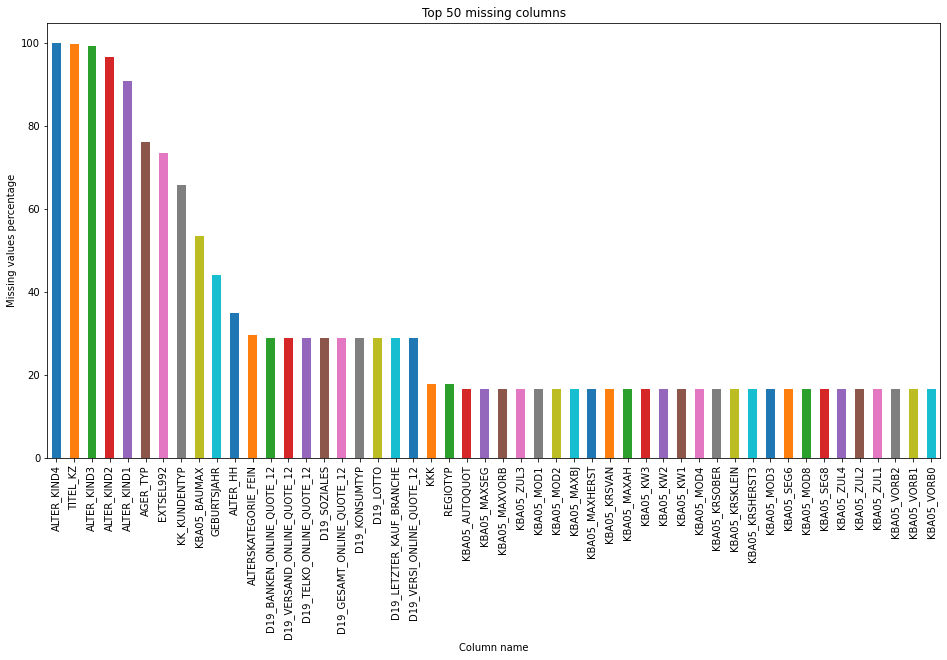

In [40]:
ax = null_col_azd_percentage.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(16,8),color=colors, title='Top 50 missing columns')
ax.set_xlabel("Column name")
ax.set_ylabel("Missing values percentage")

Most columns are missing less than 20% of their values.The top 5 columns are missing more than 90% of their values. 

In [43]:
print("On average, columns are missing {}% of their total values.".format(round(null_col_azd_percentage.mean(),2)))
print("94% of columns have a missing share of {}% or less.".format(round(null_col_azd_percentage.quantile(0.9442),2)))

On average, columns are missing 11.49% of their total values.
94% of columns have a missing share of 24.77% or less.


In [44]:
null_col_azd_percentage.describe()

count    366.000000
mean      11.490638
std       13.831121
min        0.000000
25%        0.544646
50%       11.871354
75%       13.073637
max       99.864792
dtype: float64

In [45]:
#columns to drop > 25 missing values%
null_col_drop = list(null_col_azd_percentage[null_col_azd_percentage>25].index)
print(null_col_drop)
print(len(null_col_drop))

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
21


### Categorical Columns

In [17]:
cat_columns = azdias.select_dtypes(['object']).columns
cat_columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [18]:
for col in cat_columns:
    print("Column {}: {} unique values".format(col, azdias[col].nunique()))

Column CAMEO_DEU_2015: 44 unique values
Column CAMEO_DEUG_2015: 9 unique values
Column CAMEO_INTL_2015: 21 unique values
Column D19_LETZTER_KAUF_BRANCHE: 35 unique values
Column EINGEFUEGT_AM: 5162 unique values
Column OST_WEST_KZ: 2 unique values


'OST_WEST_KZ': will be converted to 0 and 1 | 0 = OST and 1 = WEST <br>
'EINGEFUEGT_AM':will be converted to datetime year <br>
'CAMEO_DEU_2015': will be kept and the other columns will be dropped as they are similar <br>
'D19_LETZTER_KAUF_BRANCHE:': will be dropped.<br>

In [47]:
# Drop column 'LNR'- unique identifier of each person and will be dropped
drop_cols = null_col_drop + ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE','LNR']
print("{} columns will be removed: {}".format(len(drop_cols), drop_cols))

25 columns will be removed: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'LNR']


### Missing Rows

In [56]:
null_row_azd = azdias.isnull().sum(axis=1)
null_row_azd

0         259
1          18
2           8
3          10
4           8
         ... 
891216     14
891217     12
891218     11
891219      8
891220     21
Length: 891221, dtype: int64

Text(0.5, 1.0, 'Distribution of missing row values')

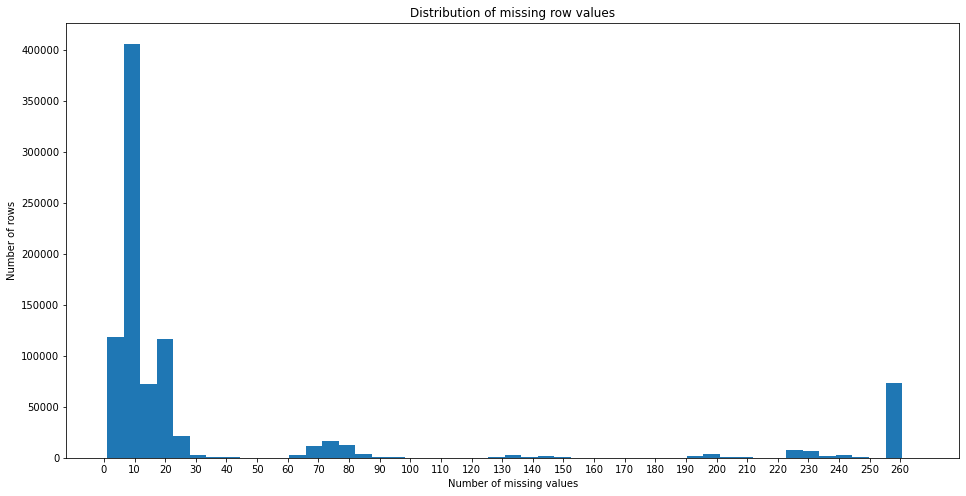

In [57]:
#Missing values in df rows
null_rows = azdias.isnull().sum(axis=1)
plt.figure(figsize=(16,8))
plt.hist(null_rows, bins=np.linspace(min(null_rows), max(null_rows)+1))

plt.xticks(np.arange(min(null_rows-1), max(null_rows)+1, 10))
plt.ylabel('Number of rows')
plt.xlabel('Number of missing values')
plt.title('Distribution of missing row values')

In [58]:
null_row_azd.describe()

count    891221.000000
mean         42.055735
std          76.362274
min           1.000000
25%           7.000000
50%          10.000000
75%          20.000000
max         265.000000
dtype: float64

In [65]:
null_row_azd.sort_index().cumsum()

0              259
1              277
2              285
3              295
4              303
            ...   
891216    37480902
891217    37480914
891218    37480925
891219    37480933
891220    37480954
Length: 891221, dtype: int64

#### Total number of rows missing: 37480954

In [69]:
#All rows with more than 20 rows missing will be removed
print("75% of rows have a missing share of {}% or less.".format(null_row_azd.quantile(0.75)))

75% of rows have a missing share of 20.0% or less.


### Data Cleaning 

In [152]:
def df_clean(df,test_df=False):
    """
    Function to clean a dataframe and prepare data for ML use.
    
    Input: 
    df - Dataframe to be cleaned
    cols_to_drop - Columns of df to be dropped
    (test_df - True if dataframe is mailout_test dataframe)
    
    Output:
    df_clean - cleaned dataframe
    """
    cols_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
         'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO',
         'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992',
         'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
         'D19_LETZTER_KAUF_BRANCHE', 'LNR']
    
    #Drop columns
    df_clean = df.drop(cols_to_drop, axis=1)
    
    #Drop rows
    if test_df==True:
        rows_dropped = 0
    else:
        rows_dropped = sum(df_clean.isnull().sum(axis=1) > 20)
        df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 20]
    
    #'EINGEFUEGT_AM' and 'OST_WEST_KZ' transformations
    df_clean['EINGEFUEGT_AM'] = pd.to_datetime(df_clean['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
    df_clean['OST_WEST_KZ'].replace('O', 0, inplace=True)
    df_clean['OST_WEST_KZ'].replace('W', 1, inplace=True)
    df_clean['OST_WEST_KZ'] = pd.to_numeric(df_clean['OST_WEST_KZ'], errors = 'coerce')
        
    #Print info about default and cleaned dataset
    print("Original datasest shape: {} ---> New dataset shape: {}".format(df.shape, df_clean.shape))
    print("Rows dropped: {} , Columns dropped: {}".format(rows_dropped, len(cols_to_drop)))
    print(df_clean.dtypes.value_counts())
    
    return df_clean    

In [153]:
azdias_new = df_clean(azdias)

Original datasest shape: (891221, 366) ---> New dataset shape: (734818, 342)
Rows dropped: 156403 , Columns dropped: 25
float64    254
int64       87
object       1
dtype: int64


In [155]:
#customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
customers_new = df_clean(customers)

Original datasest shape: (191652, 366) ---> New dataset shape: (133914, 342)
Rows dropped: 57738 , Columns dropped: 25
float64    249
int64       92
object       1
dtype: int64


### Data Transformation - Imputation- Features Pipeline

#### Continuous Numeric 

In [83]:
#Columns with Continuous numeric values
continuous_numeric = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']

In [84]:
#Identify data skewness
skewed_col = []
for col in continuous_numeric:
    if col == 'GEBURTSJAHR':
        continue 
    else:    
        skewness = skew(azdias_new[col].dropna())
        print("{}, Skewness: {}".format(col, round(skewness,1)))
        if abs(skewness) > 1:
             skewed_col.append(col)
                

ANZ_HAUSHALTE_AKTIV, Skewness: 8.7
ANZ_HH_TITEL, Skewness: 22.4
ANZ_PERSONEN, Skewness: 1.8
ANZ_TITEL, Skewness: 18.1
KBA13_ANZAHL_PKW, Skewness: 1.3
MIN_GEBAEUDEJAHR, Skewness: 3.1


In [85]:
continuous_numeric_pipe = Pipeline(steps=[
    ("log_transform_sk", FunctionTransformer(np.log1p)),
    ("imputer_sk", SimpleImputer(missing_values=np.nan, strategy='median')),
    ("scaler_sk", StandardScaler())
])

#### Categorical

In [86]:
categorical_col = list(azdias_new.select_dtypes(['object']).columns)
categorical_col

['CAMEO_DEU_2015']

In [87]:
categorical_pipe = Pipeline(steps=[
    ('imputer_c', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot_c', OneHotEncoder(handle_unknown='ignore'))
])

#### Numerical

In [89]:
numerical_col = list(set(azdias_new.columns) - set(skewed_col) - set(categorical_col))

In [90]:
# Transform-impute Pipeline
numerical_pipe = Pipeline(steps=[
    ('imputer_n', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler_n', StandardScaler())
])

### Transformation Pipeline

In [93]:
def transformer():
    
    continuous_numeric_pipe = Pipeline(steps=[
        ("log_transform_sk", FunctionTransformer(np.log1p)),
        ("imputer_sk", SimpleImputer(missing_values=np.nan, strategy='median')),
        ("scaler_sk", StandardScaler())
    ])
    
    categorical_pipe = Pipeline(steps=[
        ('imputer_c', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot_c', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    numerical_pipe = Pipeline(steps=[
        ('imputer_n', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler_n', StandardScaler())
    ])
    
    transformers = [
       ('skewed', continuous_numeric_pipe, skewed_col),
       ('categorical', categorical_pipe, categorical_col),
       ('numerical', numerical_pipe, numerical_col)]
    
    column_transformer = ColumnTransformer(transformers = transformers)
    
    return column_transformer

In [91]:
transformers = [
   ('skewed', continuous_numeric_pipe, skewed_col),
   ('categorical', categorical_pipe, categorical_col),
   ('numerical', numerical_pipe, numerical_col)]

In [92]:
#Applies transformers to columns of an array or pandas DataFrame.
column_transformer = ColumnTransformer(transformers = transformers)

In [94]:
azdias_scaled = column_transformer.fit_transform(azdias_new)

In [95]:
#column names from one hot encoded features
one_hot_col = list(column_transformer.transformers_[1][1].named_steps['onehot_c'].get_feature_names(categorical_col))

In [96]:
#column names for transformed dataframe
column_names = skewed_col + one_hot_col + numerical_col

In [98]:
#Transformed dataframe
azdias_scaled = pd.DataFrame(azdias_scaled, columns=[column_names])

In [99]:
#Verify data type
azdias_scaled.dtypes.value_counts()

float64    385
dtype: int64

In [100]:
# pickle dataframes to speed-up data loading next time
#azdias_scaled.to_pickle('azdias_scaled.pickle')

In [101]:
azdias_scaled = pd.read_pickle('azdias_scaled.pickle')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA- Principal Component Analysis

In [102]:
#choose the minimum number of principal components such that 95% of the variance is retained.
pca = PCA(0.95)

In [103]:
# Fit PCA object
pca.fit(azdias_scaled)

PCA(n_components=0.95)

In [104]:
#219 components explain 95% of variance in the dataset
pca.n_components_

219

The dataset can be reduced to almost half of its feature while only losing 5% variance.

In [105]:
pca = PCA(n_components=219).fit(azdias_scaled)

In [106]:
principalComponents = pca.transform(azdias_scaled)

In [107]:
principalDf = pd.DataFrame(data = principalComponents)
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,-4.574306,4.587763,4.339939,-5.864633,0.578207,-1.354570,-4.571444,0.446999,-0.393234,-1.813637,...,-0.245133,-0.865213,-0.387089,-0.231592,-0.119353,-0.228142,-0.235695,0.538362,0.428042,-0.162662
1,-0.173159,3.058741,-0.474481,-2.890415,4.226001,-4.864889,4.432677,-1.620973,1.501626,0.878951,...,-0.188132,-0.376590,-0.056133,0.406359,-0.247177,-0.827960,0.185109,-0.710509,-0.653127,0.613104
2,4.287007,2.604346,-5.434859,-2.683625,-0.538089,-0.809405,-1.595718,-1.507996,-2.916739,-2.335192,...,0.586548,0.118035,-0.702031,-0.233485,0.088609,-0.138171,0.424371,-0.377559,-0.662899,-0.044662
3,5.047279,-0.843923,8.793446,6.585534,-3.213677,2.737615,2.984859,-3.210748,-0.321481,-3.584458,...,0.578680,0.130242,0.047773,-1.220749,0.356187,-0.770398,0.193191,0.345627,-1.256600,1.170789
4,2.295196,3.028521,-2.089885,-2.744686,1.603110,0.227879,-0.385361,-2.066762,0.763373,-2.240015,...,-0.912863,0.239670,-0.711969,-0.069998,0.182696,-0.474649,-0.561721,0.152035,-0.242318,0.342678


In [108]:
pca.explained_variance_

array([29.13759093, 17.86084612, 17.00330131, 13.30123499,  8.40643704,
        7.13418807,  6.80330263,  6.08580506,  5.45510085,  5.05731827,
        4.60382275,  4.26902518,  4.09065705,  3.65693469,  3.40274446,
        3.29472115,  3.18522688,  3.11004677,  2.98624127,  2.88997126,
        2.71688628,  2.67106665,  2.50683262,  2.41717483,  2.33395912,
        2.30091236,  2.26363742,  2.22102231,  2.13586846,  2.11856006,
        2.0032264 ,  1.99478948,  1.93527875,  1.91744464,  1.85469976,
        1.7752263 ,  1.76667686,  1.68993811,  1.65812449,  1.60847558,
        1.59188758,  1.55329575,  1.52338308,  1.5062506 ,  1.45901441,
        1.44219114,  1.42737875,  1.3946612 ,  1.37530048,  1.3660428 ,
        1.35059689,  1.33551084,  1.31638094,  1.28563172,  1.27915265,
        1.26324354,  1.23400668,  1.22720243,  1.20739928,  1.18205662,
        1.17417071,  1.15547944,  1.12296763,  1.11961653,  1.10094505,
        1.08790266,  1.08405311,  1.0663824 ,  1.05677733,  1.03

In [109]:
#First 5 components explain 25% of variance
variance_5 = pca.explained_variance_ratio_[0:5]*100
print(variance_5)
print(variance_5.sum())

[8.52068133 5.22303228 4.97226117 3.88966902 2.45828735]
25.06393116165813


In [110]:
def pca_features(pca, pca_component,features):
    """
    Returns sorted weights for each feature. 
    
    Input:
        pca - fitted PCA object
        pca_component - PCA component of interest
        features - original feature names(list)
    
    Output:
        None
    """
    weights = pca.components_[pca_component]
    pca_features = pd.DataFrame(weights, index = features, columns=['weight'])
    
    return pca_features.sort_values(by='weight', ascending=False).round(2)


In [112]:
# 1st component is comprised of the following features
pca_features(pca, 0, azdias_scaled.columns).head(10)

,weight
MOBI_REGIO,0.14
PLZ8_ANTG1,0.13
KBA13_ANTG1,0.13
LP_STATUS_FEIN,0.13
KBA05_ANTG1,0.13
LP_STATUS_GROB,0.13
MOBI_RASTER,0.13
KBA05_AUTOQUOT,0.13
KBA05_GBZ,0.12
KBA13_AUTOQUOTE,0.12


In [113]:
pca_features(pca, 0, azdias_scaled.columns).tail(10)

,weight
ORTSGR_KLS9,-0.11
EWDICHTE,-0.11
HH_EINKOMMEN_SCORE,-0.13
PLZ8_BAUMAX,-0.13
PLZ8_ANTG4,-0.13
KBA13_BAUMAX,-0.13
KBA13_ANTG4,-0.13
KBA13_ANTG3,-0.13
PLZ8_ANTG3,-0.13
ANZ_HAUSHALTE_AKTIV,-0.13


In [114]:
pca_features(pca, 1, azdias_scaled.columns).head(10)

,weight
KBA13_HERST_BMW_BENZ,0.18
KBA13_MERCEDES,0.15
KBA13_SEG_OBEREMITTELKLASSE,0.15
KBA13_BMW,0.14
KBA13_SITZE_4,0.14
KBA13_SEG_SPORTWAGEN,0.14
KBA05_HERST1,0.13
KBA13_KMH_211,0.13
KBA13_KMH_250,0.12
KBA13_KW_121,0.12


In [115]:
pca_features(pca, 1, azdias_scaled.columns).tail(10)

,weight
KBA13_HERST_FORD_OPEL,-0.10
KBA13_SEG_KLEINST,-0.10
KBA13_HERST_ASIEN,-0.10
KBA13_KW_0_60,-0.11
KBA13_SEG_KOMPAKTKLASSE,-0.11
KBA13_HALTER_25,-0.12
KBA13_KMH_180,-0.12
KBA13_KMH_140_210,-0.13
KBA13_SEG_KLEINWAGEN,-0.13
KBA13_SITZE_5,-0.14


In [116]:
pca_features(pca, 2, azdias_scaled.columns).head(10)

,weight
ONLINE_AFFINITAET,0.16
PRAEGENDE_JUGENDJAHRE,0.16
CJT_TYP_2,0.16
CJT_TYP_1,0.15
FINANZ_SPARER,0.15
D19_GESAMT_ANZ_24,0.14
D19_GESAMT_ANZ_12,0.13
FINANZ_UNAUFFAELLIGER,0.13
D19_VERSAND_ANZ_24,0.13
SEMIO_PFLICHT,0.13


In [117]:
pca_features(pca, 2, azdias_scaled.columns).tail(10)

,weight
D19_GESAMT_DATUM,-0.13
D19_VERSAND_ONLINE_DATUM,-0.13
CJT_KATALOGNUTZER,-0.13
FINANZ_VORSORGER,-0.13
ALTERSKATEGORIE_GROB,-0.13
D19_GESAMT_ONLINE_DATUM,-0.13
CJT_TYP_4,-0.14
CJT_TYP_6,-0.14
CJT_TYP_3,-0.15
CJT_TYP_5,-0.15


### K-means
#### The Elbow Method is one of the most popular methods to determine this optimal value of k.
The general population can be clustered into appropriate groups using clustering

In [143]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
azdias_sample = azdias_scaled.sample(40000, random_state=5)

inertias = []
distortions = []
mapping1 = {}
mapping2 = {}

K = range(1, 16)

for k in K:
    km = KMeans(n_clusters=k)
    km.fit(azdias_sample)
    
    distortions.append(sum(np.min(cdist(azdias_sample, km.cluster_centers_,'euclidean'), axis=1)) / azdias_sample.shape[0])
    inertias.append(km.inertia_)
    
    mapping1[k] = sum(np.min(cdist(azdias_sample, km.cluster_centers_,'euclidean'), axis=1)) / azdias_sample.shape[0]
    mapping2[k] = km.inertia_

In [119]:
for key, val in mapping1.items():
    print(f'{key} : {val}')


1 : 18.313434316869433
2 : 17.753271896600044
3 : 17.495575439778634
4 : 17.32366138708857
5 : 17.176837807131292
6 : 17.064834574744506
7 : 16.966278846833017
8 : 16.89700885987906
9 : 16.825279858466942
10 : 16.773130317185444
11 : 16.72663948852551
12 : 16.692954866135164
13 : 16.657715067280527
14 : 16.62289200917871
15 : 16.593690873651127


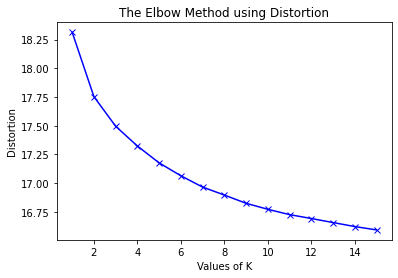

In [120]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

#The point where this distortion declines the most is the elbow point.
#Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters.
#Typically, the Euclidean distance metric is used.

In [121]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 13660771.169993136
2 : 12831229.964467688
3 : 12458343.038032185
4 : 12214078.8402085
5 : 12017037.418687703
6 : 11857895.118738756
7 : 11724376.874838015
8 : 11624755.100261476
9 : 11523876.576321572
10 : 11453239.149201091
11 : 11389878.629630199
12 : 11338644.81687863
13 : 11290997.170638422
14 : 11245208.646951122
15 : 11204972.697795218


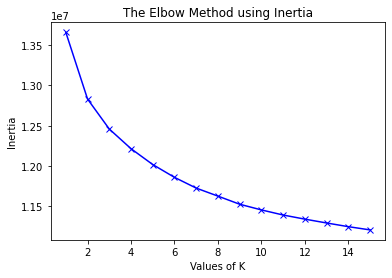

In [122]:
plt.plot(K, inertias, 'bx-')
#plt.xlim([0, 10])
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

#Inertia: The sum of squared distances of samples to their closest cluster center.

In [126]:
#customers = pd.read_pickle('customers.pickle')

In [165]:
#customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
#customers_new = df_clean(customers,drop_cols)

Original datasest shape: (191652, 366) ---> New dataset shape: (132104, 342)
Rows dropped: 59548 , Columns dropped: 25
float64    249
int64       92
object       1
dtype: int64


### PCA & K-Means Pipeline 

In [123]:
#Initial Parameters
pca_comp = 219
clusters_n = 10

In [124]:
pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('pca', PCA(n_components = pca_comp)),
    ('cluster', KMeans(n_clusters = clusters_n))
])

In [125]:
# Fit pipeline | clustered general population dataframe
pipeline.fit(azdias_new)
azdias_clustered = pd.DataFrame(pipeline.predict(azdias_new), columns = ['Cluster'])

In [126]:
# Clustered customers dataframe
customers_clustered = pd.DataFrame(pipeline.predict(customers_new), columns = ['Cluster'])

In [129]:
#azdias_clustered.to_pickle('azdias_clust')
#customers_clustered.to_pickle('customers_clust')

In [128]:
azdias_clustered = pd.read_pickle('azdias_clust')
customers_clustered = pd.read_pickle('customers_clust')

In [130]:
# Get cluster COUNTS in each dataset
azdias_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

In [131]:
azdias_clusters

0     51116
1     97590
2    104286
3     48591
4     94522
5     92401
6     46408
7     58291
8     74016
9     67597
Name: Cluster, dtype: int64

In [132]:
#Dataframe with clusters for both datasets 
clusters = pd.concat([azdias_clusters, customer_clusters], axis=1)
clusters.columns = ['population_count', 'customers_count']
clusters.index += 1
clusters

,population_count,customers_count
1,51116,2589
2,97590,30586
3,104286,1152
4,48591,6020
5,94522,31833
6,92401,15201
7,46408,3083
8,58291,3863
9,74016,1236
10,67597,38351


In [133]:
# Calculate percentage of each cluster
clusters['population %'] = clusters['population_count']/clusters['population_count'].sum()*100
clusters['customers %'] = clusters['customers_count']/clusters['customers_count'].sum()*100
clusters['diff_share'] = clusters['customers %']  - clusters['population %'] 
clusters

,population_count,customers_count,population %,customers %,diff_share
1,51116,2589,6.956280,1.933330,-5.022950
2,97590,30586,13.280840,22.840032,9.559192
3,104286,1152,14.192086,0.860254,-13.331832
4,48591,6020,6.612658,4.495422,-2.117235
5,94522,31833,12.863321,23.771226,10.907905
6,92401,15201,12.574678,11.351315,-1.223363
7,46408,3083,6.315577,2.302224,-4.013354
8,58291,3863,7.932713,2.884687,-5.048025
9,74016,1236,10.072698,0.922980,-9.149718
10,67597,38351,9.199149,28.638529,19.439381


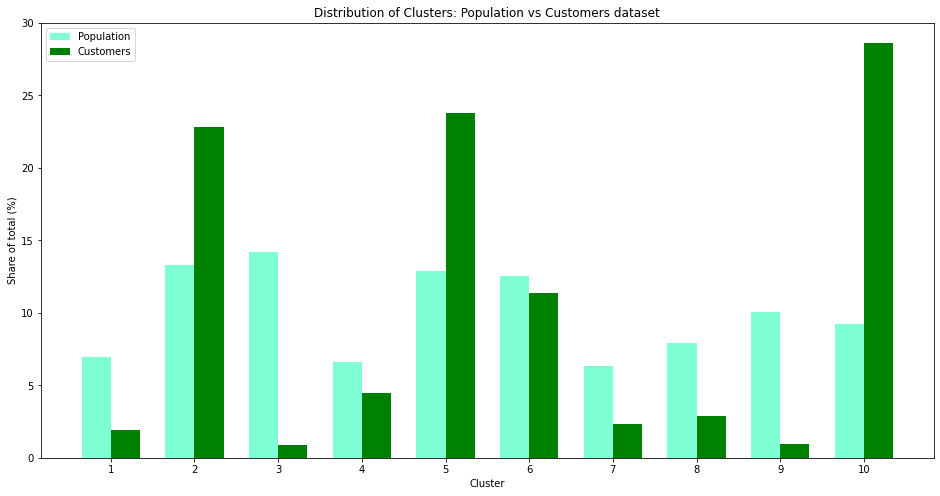

In [136]:
# Plot clusters 
fig, ax = plt.subplots(figsize=(16,8))

ind = np.arange(clusters_n)   # x -axis
width = 0.35                  # bar width

plt_1 = ax.bar(ind, clusters['population %'], width, bottom=0,color = 'aquamarine')
plt_2 = ax.bar(ind + width, clusters['customers %'], width, bottom=0,color = 'green')

ax.set_title('Distribution of Clusters: Population vs Customers dataset')
ax.set_ylabel('Share of total (%)')
ax.set_xlabel('Cluster')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(clusters.index)
ax.set_ylim(0,30)
ax.legend((plt_1[0], plt_2[0]), ('Population', 'Customers'))
ax.autoscale_view()

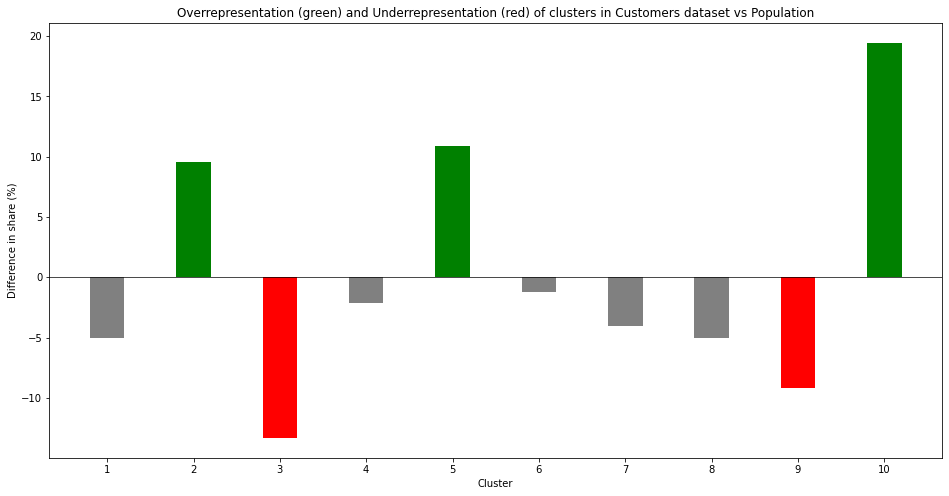

In [140]:
#Cluster differences
fig, ax = plt.subplots(figsize=(16,8))

ind = np.arange(clusters_n)
width = 0.4         

bar_colors = ('grey','green','red','grey','green','grey','grey','grey','red','green')

plt_1 = ax.bar(ind, clusters['diff_share'], width, color = bar_colors)

ax.set_title('Overrepresentation (green) and Underrepresentation (red) of clusters in Customers dataset vs Population')
ax.set_ylabel('Difference in share (%)')
ax.set_xlabel('Cluster')
ax.axhline(linewidth=0.7, color='black')

ax.set_xticks(ind)
ax.set_xticklabels(clusters.index)
#ax.legend()
ax.autoscale_view()

In [141]:
# The cluster analysis and interpretation consist of calculating the cluster centroids for 
#all features and inverse transform them to original feature scales.

def cluster_attrib(pipeline, numerical_col, skewed_col, column_names):
    """
    Transforms clusters centers, by PCA inverse transform.
    Inverse scales for numerical attributes and log_attributes.
    Inverse exponential transformation for log_attributes.
    
        Input:
            pipeline: cluster pipeline(object)
            numerical_col: numerical attributes, rescaled(list)
            log_attributes: attributes with logarithmic transformation, rescaled(list)
            column_names: names of all columns produced by ColumnTransformer


        Output:
            cluster_centers_df: DataFrame of cluster_centers with their attribute values(df)

    """
    pca_components = pipeline.named_steps['pca']
    kmeans = pipeline.named_steps['cluster']
    transformer =  pipeline.named_steps['transformer']

    cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=column_names)

    scaler_n = transformer.named_transformers_['numerical'].named_steps['scaler_n']
    scaler_sk = transformer.named_transformers_['skewed'].named_steps['scaler_sk']
    log_transform_sk = transformer.named_transformers_['skewed'].named_steps['log_transform_sk']

    cluster_centers_df[numerical_col] = scaler_n.inverse_transform(cluster_centers_df[numerical_col])
    cluster_centers_df[skewed_col] = scaler_sk.inverse_transform(cluster_centers_df[skewed_col])
    cluster_centers_df[skewed_col] = log_transform_sk.inverse_transform(cluster_centers_df[skewed_col])
    cluster_centers_df.index += 1

    return cluster_centers_df  

In [142]:
cluster_centers_df = cluster_attrib(pipeline, numerical_col, skewed_col, column_names)
cluster_centers_df.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,...,KBA13_BAUMAX,KBA13_KRSHERST_FORD_OPEL,KBA13_HALTER_60,KBA13_FAB_SONSTIGE,PLZ8_ANTG4,FINANZ_MINIMALIST,EWDICHTE,KBA13_SEG_SONSTIGE,KBA13_SEG_MINIVANS,D19_WEIN_FEINKOST
1,2.450751,0.037430,0.828186,0.001982,6.035851,7.597937,0.004082,-0.000315,0.002294,-0.001155,...,3.574673,3.343970,3.129842,3.981752,1.438151,2.433020,4.399832,3.480391,2.893739,0.260497
2,1.016003,0.004487,0.876774,0.001986,6.432305,7.597812,0.014421,0.007010,0.005457,0.027168,...,1.037770,3.147442,3.309780,2.550225,0.173958,4.373357,2.614869,2.837222,3.371033,0.315911
3,1.684875,0.009989,0.804920,0.000874,6.490639,7.597732,0.014099,0.005447,0.003419,0.011379,...,1.198445,3.012810,3.134938,2.667884,0.392189,2.140950,3.379377,2.903474,3.306159,0.086526
4,2.549246,0.117756,0.779609,0.006968,6.035023,7.597501,0.017220,0.004531,0.010489,0.009303,...,4.299776,2.155135,1.922134,3.632194,1.515874,2.373587,5.737799,3.354557,2.227090,0.215206
5,0.927679,0.004567,1.346464,0.002782,6.432917,7.598019,0.018217,0.007773,0.007744,0.032641,...,1.065726,3.067129,3.291718,2.630888,0.206623,3.924651,2.810440,2.858020,3.345439,1.300290


In [144]:
target_df = cluster_centers_df.T[[2,5,10,3,9]]

In [145]:
target_df.columns=['Target_cluster_2','Target_cluster_5','Target_cluster_10','Non-Target_cluster_3','Non-Target_cluster_9']

In [146]:
target_df[target_df.std(axis=1)>1.5]

,Target_cluster_2,Target_cluster_5,Target_cluster_10,Non-Target_cluster_3,Non-Target_cluster_9
D19_KONSUMTYP_MAX,6.136881,2.303843,4.451249,7.318042,7.337636
AKT_DAT_KL,3.370823,2.460624,3.206871,6.618513,6.371015
VK_DISTANZ,7.854193,3.980604,6.243343,9.525835,9.493877
LP_LEBENSPHASE_FEIN,17.078793,29.855299,20.064214,9.583810,7.117255
LP_STATUS_FEIN,7.803849,7.908741,7.263306,3.895805,1.715301
VK_DHT4A,6.755057,2.631049,5.284133,7.170402,7.377971
D19_GESAMT_ONLINE_DATUM,8.675864,3.841470,7.080302,9.037774,8.863520
VERDICHTUNGSRAUM,2.454237,2.913530,5.759242,3.617463,7.063893
D19_VERSAND_ONLINE_DATUM,8.977611,4.220924,7.429300,9.219214,9.053129
EINGEZOGENAM_HH_JAHR,2000.868381,2000.933155,2001.652572,2005.742488,2005.837932


In [147]:
target_df.to_pickle('target_df')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [148]:
mailout_train = pd.read_csv('Arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';',low_memory=False)

In [149]:
mailout_train.shape

(42962, 367)

In [150]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [156]:
mailout_train_new = df_clean(mailout_train)

Original datasest shape: (42962, 367) ---> New dataset shape: (33932, 343)
Rows dropped: 9030 , Columns dropped: 25
float64    249
int64       93
object       1
dtype: int64


In [157]:
mailout_train_new.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [158]:
X = mailout_train_new.drop(['RESPONSE'], axis=1)

In [159]:
y = mailout_train_new['RESPONSE']

In [160]:
ml_models = {'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': xgb.XGBClassifier()
            }

In [161]:
def random(df):
    """
    Returns randomized X and y.
    
        Input:
            df:DataFrame
            
        Output:
            Randomized X and y
    """
    df_rand = df.sample(frac=1 ,random_state=42)
    y_rand = df_rand['RESPONSE']
    X_rand = df_rand.drop(['RESPONSE'],axis=1)
    
    return X_rand, y_rand

In [162]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(X, y, estimator, cross_val):
    """
    Plot learning curve that shows the cross-validation score and training auc_score of an estimator 
    for varying numbers of training samples.
    
        Input:
            X: array-like of shape (n_samples, n_features)
            y: array-like of shape (n_samples)
            estimator: estimator instance implementing  “fit” and “predict” methods
            cross_val: Determines the cross-validation splitting strategy(int)

        Output:
            None
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        scoring = 'roc_auc',
        train_sizes=np.linspace(.1, 1.0, cross_val),
        
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(train_scores_mean[-1].round(2)))
    print("AUC validation score = {}".format(test_scores_mean[-1].round(2)))
    #print("Fit Times = {}".format(fit_times_mean[-1].round(2)))
    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, cross_val)*100, train_scores_mean, 'x-', color="b",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, cross_val)*100, test_scores_mean, 'x-', color="r",
             label="Cross-validation score")

    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()
    

RandomForestClassifier
AUC train score = 1.0
AUC validation score = 0.55



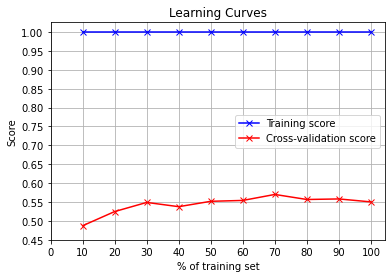

AdaBoostClassifier
AUC train score = 0.83
AUC validation score = 0.68



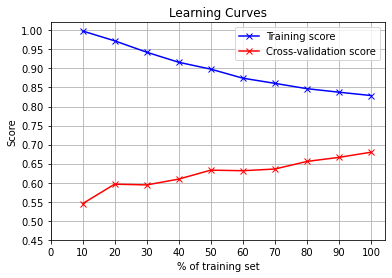

GradientBoostingClassifier
AUC train score = 0.95
AUC validation score = 0.71



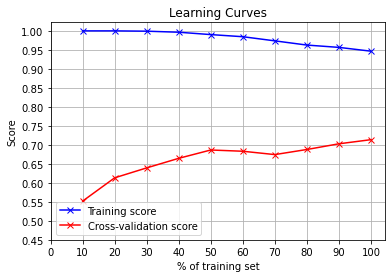

XGBClassifier


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC train score = 1.0
AUC validation score = 0.67



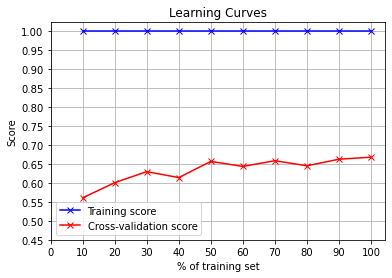

In [163]:
for key in ml_models.keys():
    print(key)
    ml_pipeline = Pipeline([
        ('transform', transformer()),
        ('model', ml_models[key])
    ])
    X, y = random(mailout_train_new)
    plot_learning_curve(X, y, ml_pipeline, 10)

AUC train score = 0.84
AUC validation score = 0.64



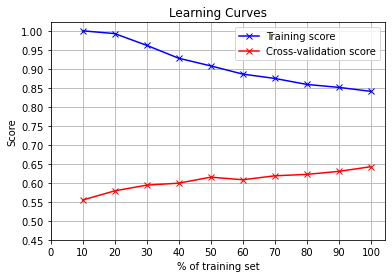

In [164]:
#Baseline   
linear_baseline = Pipeline([
    ('transform', transformer()),
    ('log_reg',LogisticRegression(max_iter=500))
])
#linear_baseline.fit(X, y).score()
plot_learning_curve(X, y, linear_baseline, 10)

We use a simple model - LogisticRegression as the baseline model

In [165]:
#GradientBoostingClassifier
gbc_pipe = Pipeline([
    ('transform', column_transformer),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

parameters = {'gbc__learning_rate': [0.1, 0.2],
              'gbc__n_estimators': [100],
              'gbc__max_depth': [3, 5],
              'gbc__min_samples_split': [2,4]
             }        
# Fit the grid search object to the training data to find optimal parameters        
grid_obj = GridSearchCV(gbc_pipe, parameters, scoring = 'roc_auc', verbose=2)
grid_obj.fit(X, y)



Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100; total time=  56.4s
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100; total time=  56.5s
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100; total time=  56.2s
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100; total time=  56.9s
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100; total time=  56.5s
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100; total time=  56.3s
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100; total time=  56.1s
[CV] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=4, gbc__n_estimators=100; total t

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('log_transform_sk',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('imputer_sk',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler_sk',
                                                                                          StandardScaler())]),
                                                                         ['ANZ_HAUSHALTE_AKTIV',
                                                                          'ANZ_H

In [166]:
# Get the estimator parameters and predict
print('Top Classifier parameters: ', grid_obj.best_params_)

#Predictions using simple model vs best model parameters
predictions = (gbc_pipe.fit(X, y)).predict_proba(X)[:, 1]

best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X)[:, 1]

print("ROC score: {:.4f}".format(roc_auc_score(y, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y, best_predictions)))

Top Classifier parameters:  {'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__min_samples_split': 4, 'gbc__n_estimators': 100}
ROC score: 0.9255
Final ROC score: 0.9276


In [167]:
# Save to file in the current working directory
gradient_boosting_pkl = "gradient_boosting.pkl"  
with open(gradient_boosting_pkl, 'wb') as file:  
    pickle.dump(best_clf, file)

Text(0.5, 1.0, 'Top 10 feautures arranged by importance')

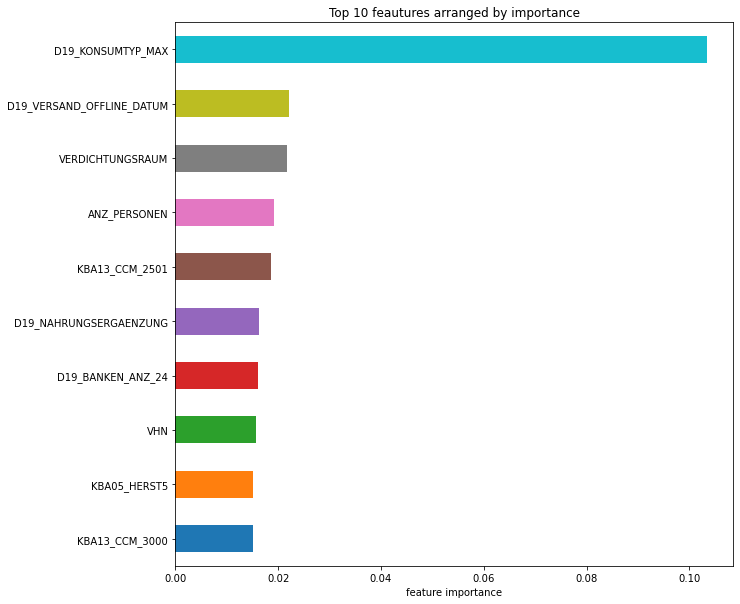

In [176]:
feature_importances = best_clf.named_steps['gbc'].feature_importances_
feature_Series = pd.Series(feature_importances,index=[''] + column_names).sort_values()[-10:]

feature_Series.plot(kind='barh',color = colors, figsize=(10,10))
plt.xlabel('feature importance')
plt.title('Top 10 feautures arranged by importance')

## Part 3: Kaggle Competition
Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [177]:
# Load best model
with open("gradient_boosting.pkl", "rb") as input_file:
    best_clf = pickle.load(input_file)

In [178]:
mailout_test = pd.read_csv('Arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';',low_memory=False)

In [179]:
kaggle_sub = pd.DataFrame(mailout_test['LNR'].copy())
#mailout_test.drop('LNR', axis=1, inplace=True)

In [181]:
mailout_test_new = df_clean(mailout_test, test_df = True)

Original datasest shape: (42833, 366) ---> New dataset shape: (42833, 342)
Rows dropped: 0 , Columns dropped: 25
float64    251
int64       90
object       1
dtype: int64


In [182]:
predictions = best_clf.predict_proba(mailout_test_new)[:,1]
kaggle_sub['RESPONSE'] = predictions

In [183]:
kaggle_sub['RESPONSE'].value_counts()

0.001534    5638
0.002934      96
0.002826      93
0.003379      88
0.003553      82
            ... 
0.002922       1
0.028496       1
0.019851       1
0.003377       1
0.003995       1
Name: RESPONSE, Length: 36074, dtype: int64

In [184]:
kaggle_sub.head()

,LNR,RESPONSE
0,1754,0.026976
1,1770,0.025624
2,1465,0.003423
3,1470,0.004135
4,1478,0.005509


In [185]:
submission = pd.read_csv('Arvato_Capstone_Example_Submission.csv')
submission['RESPONSE'] = kaggle_sub['RESPONSE']
submission.to_csv('Kaggle_Submission.csv', index=False)

In [186]:
submission.head()

,LNR,RESPONSE
0,1754,0.026976
1,1770,0.025624
2,1465,0.003423
3,1470,0.004135
4,1478,0.005509


### Public score: 0.68583

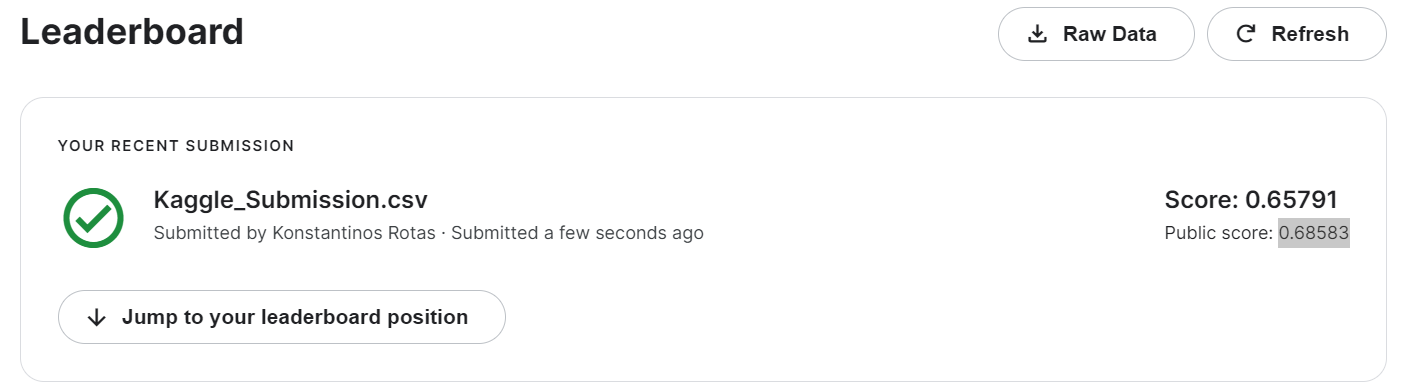